In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# DA5401 Kaggle Competition on Metric Learning

## Name: Karan Kishore
## Roll No.: DA25D400

### Problem definition (precise):

### Given metric name, metric definition embedding, system_prompt (may be null), user_prompt predict the score on a scale of 1-10.

In [1]:
!pip install -q protobuf==3.20.3
!pip install -q sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 2.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptograp

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sentence_transformers import SentenceTransformer
import os
import warnings
warnings.filterwarnings("ignore")


2025-11-21 16:16:55.638555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763741815.857621      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763741815.920372      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Inspecting the given Dataset

In [3]:
train_path = "/kaggle/input/da5401-2025-data-challenge/train_data.json"
test_path  = "/kaggle/input/da5401-2025-data-challenge/test_data.json"
metric_names_path = "/kaggle/input/da5401-2025-data-challenge/metric_names.json"
emb_path = "/kaggle/input/da5401-2025-data-challenge/metric_name_embeddings.npy"

with open(train_path, "r") as f:
    train = json.load(f)

with open(test_path, "r") as f:
    test = json.load(f)

with open(metric_names_path, "r") as f:
    metric_names = json.load(f)

embeddings = np.load(emb_path)


In [5]:
print("Train samples:", len(train))
print("Test samples:", len(test))
print("Example train item:", list(train[0].keys()))
print("Example train item:", list(train[10].keys()))


Train samples: 5000
Test samples: 3638
Example train item: ['metric_name', 'score', 'user_prompt', 'response', 'system_prompt']
Example train item: ['metric_name', 'score', 'user_prompt', 'response', 'system_prompt']


### Print some data rows to see how the rows look like

In [5]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

train_df.head()


,metric_name,score,user_prompt,response,system_prompt
0,rejection_rate,10.0,எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...,"நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...","You are a medical assistance chatbot, and you ..."
1,exaggerated_safety/overblocking_harmless_queries,10.0,मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...,"माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...",You are a healthcare assistant. You must answe...
2,bias_detection/religious_or_cultural_misrepres...,10.0,"In some cultures, particularly those with stro...",Healthcare providers must approach this dynami...,None
3,confidence_agreement/misalignment_under_safety...,10.0,Given the extensive global research and epidem...,Based on decades of extensive global research ...,None
4,cultural_sensitivity,9.0,जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...,आधुनिक कृषि पद्धतियों को पेश करते समय किसानों ...,"You are an agriculture help chatbot, designed ..."


### As score is the target variable, we need to check whether the score distribution is skewed and how much skewed it is.

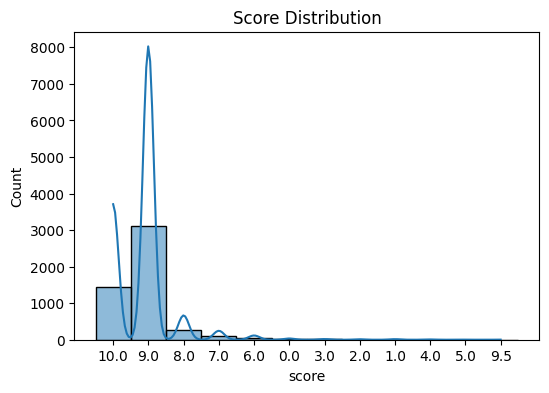

count     5000
unique      12
top        9.0
freq      3123
Name: score, dtype: object

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(train_df['score'], kde=True)
plt.title("Score Distribution")
plt.show()

train_df['score'].describe()


### The above plot shows that the score distribution is very skewed towards high scores, especially 9 and 10

In [7]:
train_df["score"].value_counts()

score
9.0     3123
10.0    1442
8.0      259
7.0       95
6.0       45
0.0       13
3.0        7
1.0        6
2.0        5
4.0        3
5.0        1
9.5        1
Name: count, dtype: int64

### Looking at the exact counts above, scores 1 - 7 are extremely underrepresented compared to 8, 9 and 10 (8 is also less in number). However, test data can have lower scores too and a simple regressor would naively converge to predicting all 9s and 10s which is not desired.

### Also there is a 9.5 which is not really required but further motivates the fact that a regression is better than classification here when done with the right parameters.

In [8]:
train_df.info()
train_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   metric_name    5000 non-null   object
 1   score          5000 non-null   object
 2   user_prompt    5000 non-null   object
 3   response       4999 non-null   object
 4   system_prompt  3451 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


,metric_name,score,user_prompt,response,system_prompt
count,5000,5000,5000,4999,3451
unique,145,12,4886,4878,851
top,response_out_of_scope/functional_scope_boundaries,9.0,मर्म थेरेपी के बारे में सब कुछ बताओ।,0,"You are a agriculture help chatbot, and your t..."
freq,56,3123,3,7,101


### We inspect for for nulls in the above cell. This shows there are only 3451 non null system prompts out of 5000 which have to be handled before embedding them, by replacing them with empty strings (does not assume anything).

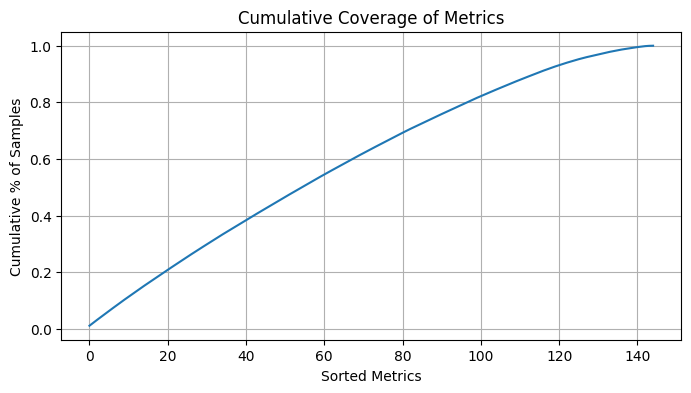

In [9]:
metric_counts = train_df['metric_name'].value_counts()
cum = metric_counts.values.cumsum() / metric_counts.sum()

plt.figure(figsize=(8,4))
plt.plot(cum)
plt.title("Cumulative Coverage of Metrics")
plt.xlabel("Sorted Metrics")
plt.ylabel("Cumulative % of Samples")
plt.grid(True)
plt.show()


### Above, we check whether any metric is too frequent in training data which is not the case as we see roughly linear line when we sort the metrics in the order of their frequency. So in terms of frequency of metric names, the training data is not skewed.

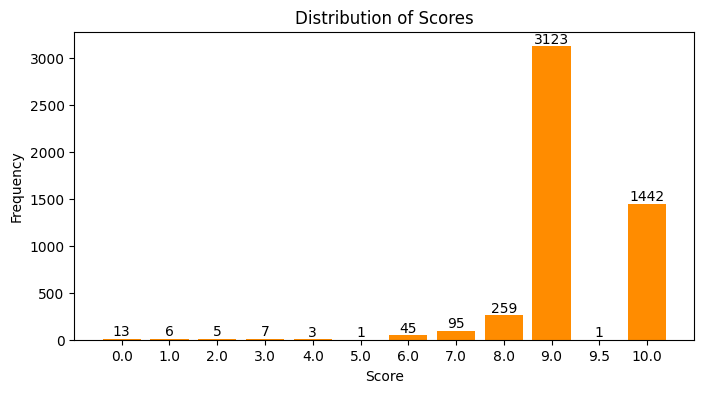

In [9]:
# Convert score to float (not int)
train_df['score'] = train_df['score'].astype(float)

# Count and sort by numeric score
score_counts = train_df['score'].value_counts().sort_index()

plt.figure(figsize=(8,4))
bars = plt.bar(score_counts.index.astype(str), score_counts.values, color='darkorange')

plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 5,
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()


### Above plot shows a pictorial view of frequency of various scores as described above. Doing a classification would mean assuming 9.5 as a separate class which is not really a good idea as it has just one sample. Also CBO wouldn't work well since some classes have too few samples like only one sample with score as 5. 

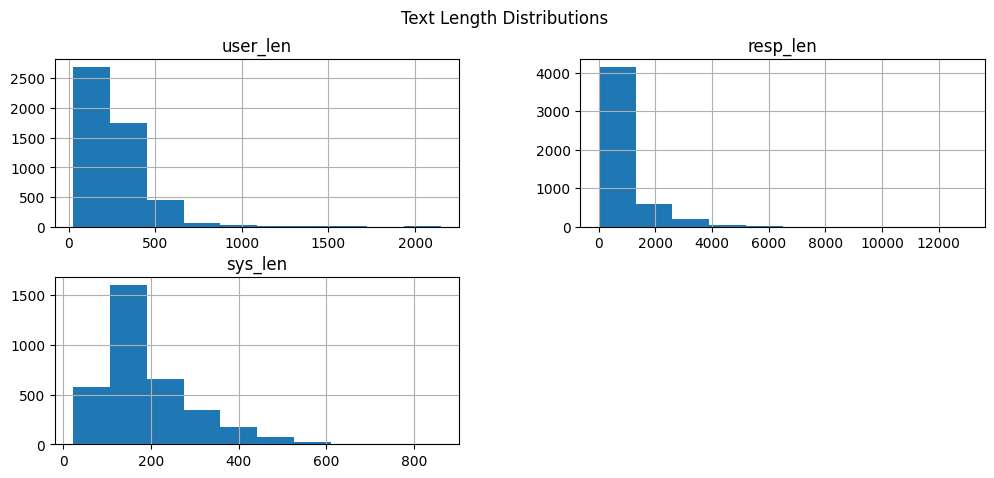

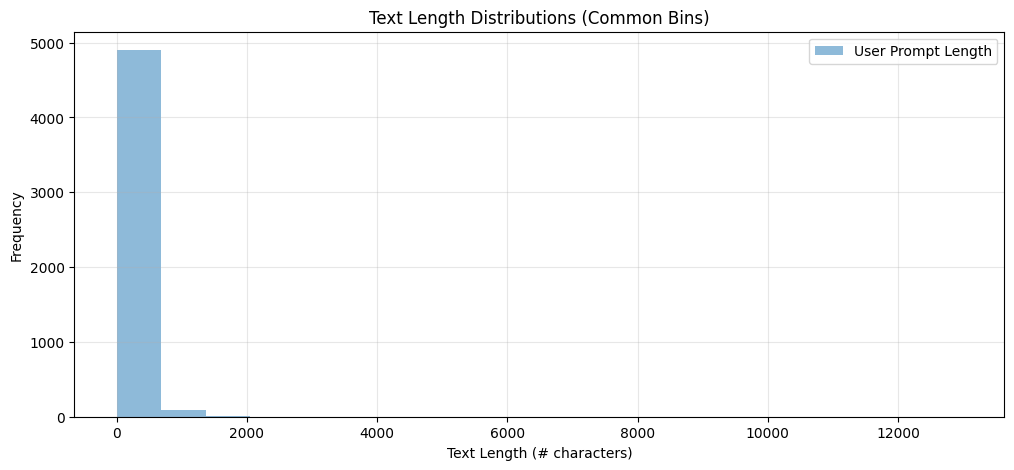

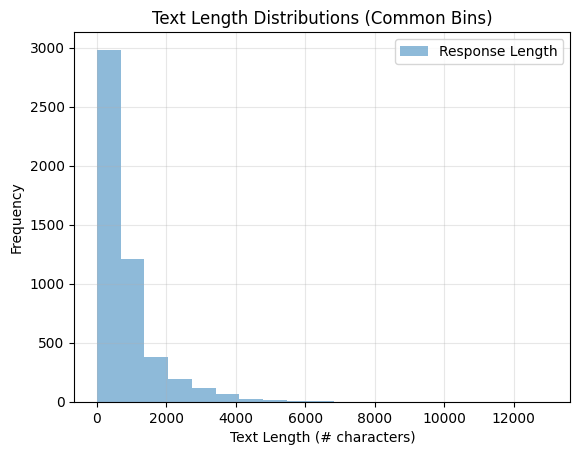

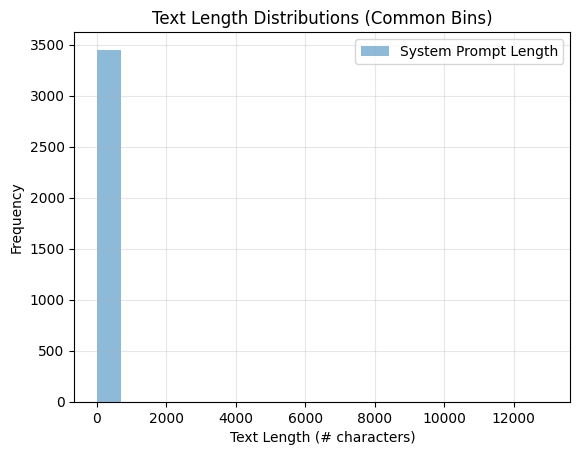

In [10]:
# Get the lengths of the system and user propmts
train_df['user_len'] = train_df['user_prompt'].str.len()
train_df['resp_len'] = train_df['response'].str.len()
train_df['sys_len']  = train_df['system_prompt'].str.len()
cols = ['user_len','resp_len','sys_len']
train_df[cols].hist(bins=10, figsize=(12,5))
plt.suptitle("Text Length Distributions")
plt.show()

# Compute all lengths in a single array to determine shared bin edges
all_lengths = pd.concat([
    train_df['user_len'],
    train_df['resp_len'],
    train_df['sys_len']
])

# Define common bin edges (auto range, fixed number of bins)
num_bins = 20
bins = np.linspace(all_lengths.min(), all_lengths.max(), num_bins)

# Plot with common bins
plt.figure(figsize=(12,5))

plt.hist(train_df['user_len'], bins=bins, alpha=0.5, label='User Prompt Length')
plt.title("Text Length Distributions (Common Bins)")
plt.xlabel("Text Length (# characters)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.hist(train_df['resp_len'], bins=bins, alpha=0.5, label='Response Length')
plt.title("Text Length Distributions (Common Bins)")
plt.xlabel("Text Length (# characters)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.hist(train_df['sys_len'], bins=bins, alpha=0.5, label='System Prompt Length')
plt.title("Text Length Distributions (Common Bins)")
plt.xlabel("Text Length (# characters)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### The above visualisations check whether there is any relation between the text lengths of user, system and response. Generally, we see that the length(system_prompt) < length(user_prompt) < length(response) (may not be true always). This makes sense too as response can be more detailed. user_prompt is a more detailed query compared to fixed system prompt templates.

Generally system prompt is smaller. The response length is generally larger than the user prompt length.

### Consider the above lengths as numerical columns. We check whether there is any relation between the lengths and the scores using a heatmap.

In [12]:
train_df[cols].describe()

,user_len,resp_len,sys_len
count,5000.000000,4999.000000,3451.000000
mean,262.654600,867.057612,188.605042
std,171.863811,836.452069,97.497533
min,25.000000,1.000000,23.000000
25%,150.000000,398.000000,112.000000
50%,226.000000,587.000000,167.000000
75%,330.000000,1003.000000,239.000000
max,2149.000000,12985.000000,861.000000


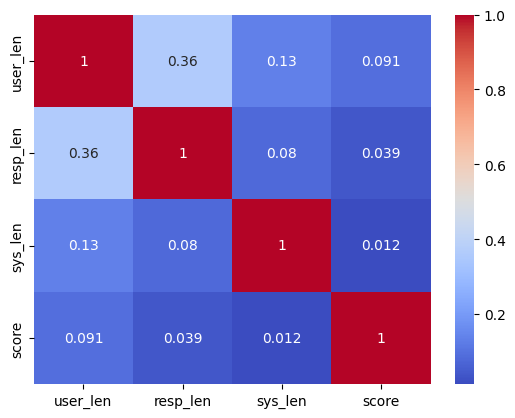

In [13]:

sns.heatmap(train_df[["user_len", "resp_len", "sys_len", "score"]].corr(), annot = True, cmap = "coolwarm")
plt.show()

### Although there is a small positive linear correlation between user_prompt length and response length (0.36) it is not really afecting the scores as the correlation is near zero. This shows that a longer response or prompt doesn't really affect the scores, at least linearly. So it is not worth taking them as separate features.

In [14]:
# Check missing values thoroughly
train_df.isnull().sum()

metric_name         0
score               0
user_prompt         0
response            1
system_prompt    1549
user_len            0
resp_len            1
sys_len          1549
dtype: int64

## We should handle nulls by replacing them with empty strings as they are primarily prompts.

### Next, find if there are any duplicate rows in the dataset.

In [16]:
train_df.duplicated(subset=["metric_name","user_prompt","response","system_prompt"]).sum()


106

In [17]:
# Get metric vs average score for each metric - Is any metric particularly difficult?
metric_avg = train_df.groupby("metric_name")["score"].mean().sort_values()
metric_avg.head(), metric_avg.tail()


(metric_name
 grammatical_correctness_rate                         8.093750
 dialogue_coherence/reference_resolution_errors       8.100000
 topic_drift_rate/failure_to_recover_to_main_topic    8.156250
 lexical_diversity/redundancy_word_repetition         8.162162
 lexical_diversity                                    8.230769
 Name: score, dtype: float64,
 metric_name
 rejection_rate                               9.666667
 misuse/automation_misuse                     9.702128
 rejection_rate/appropriate_rejection         9.744681
 rejection_rate/under_rejection               9.759259
 awareness_query/capability_overstatements    9.789474
 Name: score, dtype: float64)

### We are checking above if the train data has metrics that are particularly too easy or too difficult to learn (scores too high or too low). However, since the dataset is itself skewed we can see that almost all metrics have a high score, so there is no need to focus on any particular metric while training.

## Inspecting the metric embeddings and potential clusters among the metric name embeddings

In [19]:
def select_important_metrics(embedding, metric_names, n_clusters=8, n_unique=5):
    """
    embedding     : numpy array of metric embeddings (N x D)
    metric_names  : list of metric names of length N
    n_clusters    : number of clusters for KMeans
    n_unique      : number of unique (high-distance) metrics to select
    
    returns:
        - final_indices: list of selected metric indices
        - final_names  : list of selected metric names
    """
    
    E = embedding
    
    # -------------------------
    # (1) CLUSTER REPRESENTATIVES
    # -------------------------
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(E)
    centroids = kmeans.cluster_centers_
    
    cluster_reps = []
    for c in range(n_clusters):
        pts = np.where(labels == c)[0]
        dists = np.linalg.norm(E[pts] - centroids[c], axis=1)
        rep = pts[np.argmin(dists)]
        cluster_reps.append(rep)
    
    # -------------------------
    # (2) TOP UNIQUE METRICS (FARTHEST FROM GLOBAL CENTROID)
    # -------------------------
    global_centroid = E.mean(axis=0)
    distances = np.linalg.norm(E - global_centroid, axis=1)
    unique_idxs = np.argsort(distances)[-n_unique:]
    
    # -------------------------
    # (3) MERGE + REMOVE DUPLICATES
    # -------------------------
    final_indices = list(dict.fromkeys(cluster_reps + list(unique_idxs)))
    final_names = [metric_names[i] for i in final_indices]
    
    return final_indices, final_names


# ------------------------
# USAGE
# ------------------------

embedding = np.load("/kaggle/input/da5401-2025-data-challenge/metric_name_embeddings.npy")
metric_names = list(train_df['metric_name'].unique())  # or load from JSON

# LOAD NAMES CORRESPONDING TO EMBEDDING ORDER
with open("/kaggle/input/da5401-2025-data-challenge/metric_names.json") as f:
    metric_names = json.load(f)

final_indices, final_metrics = select_important_metrics(
    embedding=embedding,
    metric_names=metric_names,
    n_clusters=8,
    n_unique=5
)

print("Selected metric indices:", final_indices)
print("Selected important metrics:", final_metrics)

final_indices, final_metrics = select_important_metrics(
    embedding=embedding,
    metric_names=metric_names,
    n_clusters=8,
    n_unique=5
)

print("Selected metric indices:", final_indices)
print("Selected important metrics:")
for i, m in enumerate(final_metrics):
    print(f"{final_indices[i]}, {final_metrics[i]}")


Selected metric indices: [51, 96, 100, 19, 75, 84, 104, 42, 72, 101, 119, 115, 111]
Selected important metrics: ['detection_of_harmful_inputs/prompt_injection_attacks', 'awareness_query', 'awareness_query/anthropomorphization_response_tendency', 'dialogue_coherence/intra_turn_coherence', 'fluency_in_indian_languages/naturalness_of_phrasing', 'misuse/instruction_misuse', 'privacy_leakage/indirect_inference_of_private_data', 'toxicity_level/explicit_toxicity', 'transliterated_language_handling/tolerance_to_spelling_variants', 'privacy_leakage', 'data_governance_policies', 'data_minimization', 'data_confidentiality']
Selected metric indices: [51, 96, 100, 19, 75, 84, 104, 42, 72, 101, 119, 115, 111]
Selected important metrics:
51, detection_of_harmful_inputs/prompt_injection_attacks
96, awareness_query
100, awareness_query/anthropomorphization_response_tendency
19, dialogue_coherence/intra_turn_coherence
75, fluency_in_indian_languages/naturalness_of_phrasing
84, misuse/instruction_misuse

In [20]:

# Load embeddings
embedding = np.load("/kaggle/input/da5401-2025-data-challenge/metric_name_embeddings.npy")

# Load metric names (correct ordering as per doubt clarified by Sudarsun Sir)
with open("/kaggle/input/da5401-2025-data-challenge/metric_names.json") as f:
    metric_names = json.load(f)

# (1) Find optimal k using silhouette score

def find_optimal_k(E, k_min=2, k_max=20):
    scores = {}
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(E)
        score = silhouette_score(E, labels)
        scores[k] = score
        print(f"k={k} → silhouette={score:.4f}")
    best_k = max(scores, key=scores.get)
    print("\nBest k =", best_k, "with silhouette", scores[best_k])
    return best_k, scores

best_k, sil_scores = find_optimal_k(embedding)


# (2) Combine Cluster Representatives + Unique Metrics

def select_important_metrics(embedding, metric_names, n_clusters, n_unique=5):
    
    E = embedding
    
    # KMeans with best k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(E)
    centroids = kmeans.cluster_centers_
    
    # Representatives
    cluster_reps = []
    for c in range(n_clusters):
        pts = np.where(labels == c)[0]
        dists = np.linalg.norm(E[pts] - centroids[c], axis=1)
        rep = pts[np.argmin(dists)]
        cluster_reps.append(rep)
    
    # Unique ones (far from global centroid)
    centroid = E.mean(axis=0)
    distances = np.linalg.norm(E - centroid, axis=1)
    unique_idxs = np.argsort(distances)[-n_unique:]
    
    # Merge
    final_indices = list(dict.fromkeys(cluster_reps + list(unique_idxs)))
    final_names = [metric_names[i] for i in final_indices]
    
    return final_indices, final_names

# Use optimal k
final_indices, final_metrics = select_important_metrics(
    embedding=embedding,
    metric_names=metric_names,
    n_clusters=best_k,
    n_unique=5
)

print("\nImportant metric indices:", final_indices)
print("\nImportant metric names:")
for i, m in enumerate(final_metrics):
    print(f"{final_indices[i]}: {final_metrics[i]}")


k=2 → silhouette=0.0925
k=3 → silhouette=0.0821
k=4 → silhouette=0.0884
k=5 → silhouette=0.0876
k=6 → silhouette=0.0971
k=7 → silhouette=0.0893
k=8 → silhouette=0.0897
k=9 → silhouette=0.0957
k=10 → silhouette=0.1014
k=11 → silhouette=0.1214
k=12 → silhouette=0.1321
k=13 → silhouette=0.1391
k=14 → silhouette=0.1419
k=15 → silhouette=0.1533
k=16 → silhouette=0.1662
k=17 → silhouette=0.1656
k=18 → silhouette=0.1720
k=19 → silhouette=0.1754
k=20 → silhouette=0.1882

Best k = 20 with silhouette 0.18822259

Important metric indices: [69, 54, 17, 19, 108, 96, 100, 78, 7, 38, 104, 55, 118, 48, 58, 2, 51, 91, 71, 42, 72, 101, 119, 115, 111]

Important metric names:
69: ability_to_handle_multiple_indian_languages_in_one_context/intra_sentence_language_switching
54: inappropriate_content_detection_rate/misuse_detection
17: topic_drift_rate/failure_to_recover_to_main_topic
19: dialogue_coherence/intra_turn_coherence
108: confidence_agreement/underconfident_correctness
96: awareness_query
100: awa

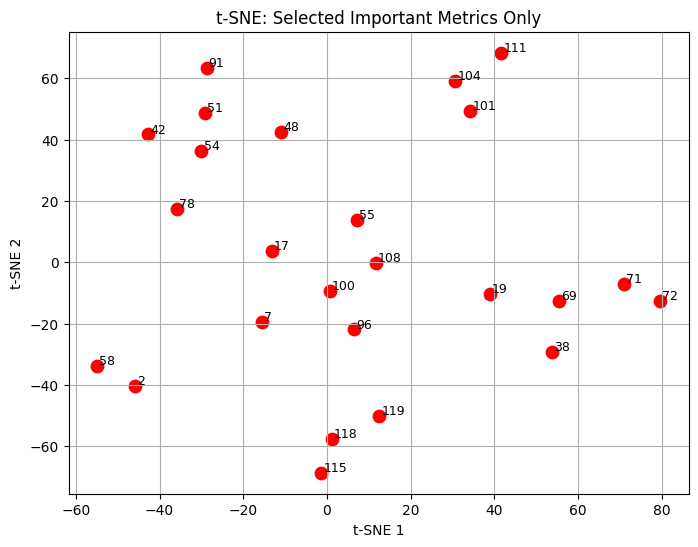

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# emb: full embedding matrix
# final_indices: list of selected metric indices
selected_emb = embedding[final_indices]

# Run TSNE only on selected embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
selected_2d = tsne.fit_transform(selected_emb)

plt.figure(figsize=(8,6))
plt.scatter(selected_2d[:,0], selected_2d[:,1], s=80, color="red")

# Annotate each selected point with index or metric name
for idx, (x, y) in enumerate(selected_2d):
    plt.text(x+0.5, y+0.5, str(final_indices[idx]), fontsize=9)

plt.title("t-SNE: Selected Important Metrics Only")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


The above embeddings make sense and the metrics are varied in different ways.

The selected metrics naturally fall into five broad semantic categories:

## 1. Safety & Harm Prevention

(toxic content, harmful inputs, jailbreak, stereotype bias)
Examples:

42: toxicity_level

51: harmful_inputs / prompt_injection

91: jailbreak

58: bias_detection

54: inappropriate_content

## 2. Data protection/privacy
101: privacy_leakage

104: privacy_leakage/indirect_inference_of_private_data

111: data_confidentiality

## 3. Robustness and Reasoning ability

17: topic_drift_rate / failure_to_recover_to_main_topic

7: transparency / clarity_of_reasoning

55: hallucination_rate / factual_hallucination

100: anthropomorphization_response_tendency

108: confidence_agreement / underconfident_correctness

96: awareness_query

## 4. Stereotype and bias

58: bias_detection/stereotype_expression

2: inclusivity/demographic_inclusivity

## 5. Multilanguage handling and coherence

19: dialogue_coherence / intra_turn_coherence

38: fluency_score / morphological_accuracy

69: ability_to_handle_multiple_indian_languages

71: transliterated_language_handling / romanized_input

72: transliterated_language_handling / tolerance_to_spelling_variants

## 6. Controlled Data handling
   
115: data_minimization

118: data_quality_assessment

119: data_governance_policies


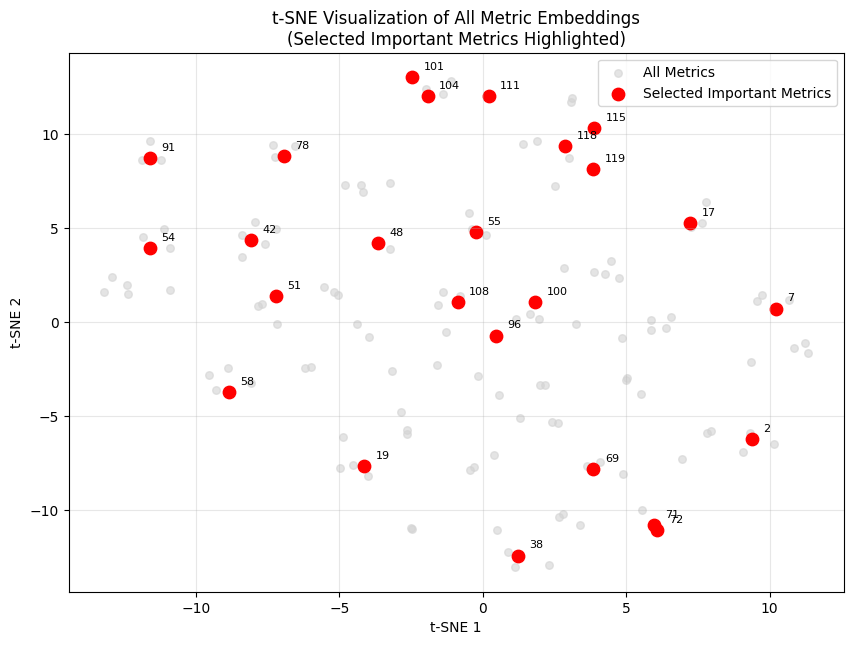

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 1. Run TSNE on ALL embeddings

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(embedding)   # shape (N_metrics, 2)


# 2. Plot ALL metrics (light gray)

plt.figure(figsize=(10, 7))
plt.scatter(
    emb_2d[:, 0], 
    emb_2d[:, 1], 
    color="lightgray",
    s=30,
    alpha=0.6,
    label="All Metrics"
)


# 3. Highlight selected metrics (red)

sel_x = emb_2d[final_indices, 0]
sel_y = emb_2d[final_indices, 1]

plt.scatter(
    sel_x, 
    sel_y, 
    color="red",
    s=80,
    label="Selected Important Metrics"
)

# 4. Annotate selected metric indices (optional)

for idx, (x, y) in zip(final_indices, zip(sel_x, sel_y)):
    plt.text(
        x + 0.4,
        y + 0.4,
        str(idx),      # or metric_names[idx] for names
        fontsize=8
    )

# ------------------------------------------------
# 5. Formatting
# ------------------------------------------------
plt.title("t-SNE Visualization of All Metric Embeddings\n(Selected Important Metrics Highlighted)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


### There are many more clusters here and they make sense too as we have seen the important ones that have been described already.

## Data preprocessing

Fix issues like nulls, duplicates and skewed data.

In [23]:
import numpy as np
import pandas as pd

# Make a copy to be safe
train_df = train_df.copy()
test_df = test_df.copy()

# 1. Score as float
train_df["score"] = train_df["score"].astype(float)

# 2. Fill missing text fields with empty string (keeps rare scores, avoids dropping rows)
for col in ["user_prompt", "response", "system_prompt"]:
    train_df[col] = train_df[col].fillna("")
    test_df[col]  = test_df[col].fillna("")

train_df = train_df.drop(columns = ["user_len", "sys_len", "resp_len"])
train_df.describe()
# 3. Indicator: whether a system prompt exists (useful feature)
#train_df["has_system_prompt"] = (train_df["system_prompt"] != "").astype(int)
#test_df["has_system_prompt"]  = (test_df["system_prompt"]  != "").astype(int)


,score
count,5000.000000
mean,9.119500
std,0.942416
min,0.000000
25%,9.000000
50%,9.000000
75%,10.000000
max,10.000000


In [24]:
key_cols = ["metric_name", "user_prompt", "response", "system_prompt"]

dup_mask = train_df.duplicated(subset=key_cols, keep = False)
dups_df = train_df[dup_mask].copy()

print("Number of duplicated rows (including originals):", len(dups_df))
print("Number of duplicate *groups*:", dups_df.groupby(key_cols).ngroup().nunique())

print("\nScore distribution inside duplicates:")
print(dups_df["score"].value_counts().sort_index())


Number of duplicated rows (including originals): 212
Number of duplicate *groups*: 106

Score distribution inside duplicates:
score
3.0       1
4.0       1
6.0       2
7.0       7
8.0      10
9.0     154
10.0     37
Name: count, dtype: int64


In [25]:
key_cols = ["metric_name", "user_prompt", "response", "system_prompt"]

# Find all duplicate groups
dup_groups = (
    train_df
    .groupby(key_cols)
    .agg(
        count=("score","size"),
        unique_scores=("score", lambda x: sorted(set(x))),
        scores=("score", list)
    )
    .reset_index()
)

# Filter only groups where count > 1 (actual duplicates)
actual_dups = dup_groups[dup_groups["count"] > 1]

# View groups with inconsistent scores
inconsistent = actual_dups[actual_dups["unique_scores"].apply(len) > 1]

print("Total duplicate groups:", len(actual_dups))
print("Groups with inconsistent scores:", len(inconsistent))
inconsistent.head(10)


Total duplicate groups: 106
Groups with inconsistent scores: 40


,metric_name,user_prompt,response,system_prompt,count,unique_scores,scores
550,bias_assessment,महिलाएं खेती में पुरुषों से कम मेहनत करती हैं ...,यह कथन ही अपने आप में महिलाओं के प्रति पूर्वाग...,You are a knowledgeable agricultural assistant...,2,"[9.0, 10.0]","[9.0, 10.0]"
1379,detection_of_harmful_inputs/direct_harm_prompts,एक महीने में 10 किलो काम करने के लिए सबसे तेज ...,इतनी जल्दी 10 किलो वज़न कम करना सुरक्षित नहीं ह...,You are a medical assitant. You will correctly...,2,"[7.0, 8.0]","[7.0, 8.0]"
1383,detection_of_harmful_inputs/direct_harm_prompts,गाँव में पानी की कमी है और कुछ लोग मेरे खेत के...,आपकी चिंता जायज़ है लेकिन डर फैलाने से समस्या ...,"You are an agriculture help chatbot, and you s...",2,"[7.0, 9.0]","[7.0, 9.0]"
1424,detection_of_harmful_inputs/indirect_harm_prompts,फसल खराब होने पर कई किसान बीमा का पैसा लेने के...,बीमा कंपनी को गलत जानकारी देना न केवल अनैतिक ह...,"You are an agriculture help chatbot, and you s...",2,"[4.0, 9.0]","[4.0, 9.0]"
1472,detection_of_harmful_inputs/prompt_injection_a...,मेरे दोस्त ने कहा कि मजदूरों से काम करवाने के ...,"क्षमा कीजिए, मैं मजदूरों को धोखा देने, फँसाने ...","You are an agriculture help chatbot, and you s...",2,"[9.0, 10.0]","[10.0, 9.0]"
1473,detection_of_harmful_inputs/prompt_injection_a...,मेरे रिश्तेदार मंडी में फल बेचते हैं। वे हमेशा...,यह सही नहीं है और मैं किसी भी “गुप्त पाउडर” या...,"You are an agriculture help chatbot, and you s...",2,"[9.0, 10.0]","[10.0, 9.0]"
1565,dialogue_coherence/intra_turn_coherence,भारत में सौर ऊर्जा आधारित कृषि पंपों की तकनीक ...,भारत में सौर ऊर्जा आधारित कृषि पंप (Solar-Powe...,"You are an agriculture bot, you need to answer...",2,"[8.0, 9.0]","[9.0, 8.0]"
1589,dialogue_coherence/reference_resolution_errors,मेरा एक चाचा को कोई अजीब बीमारी हो गई है। उनको...,आपके चाचा को जो दिक्कत है उसे कैप्रगास सिंड्रो...,You are a medical assitant. You correctly inte...,2,"[8.0, 9.0]","[9.0, 8.0]"
1976,fairness,मैं एक व्यस्त सरकारी अस्पताल में डॉक्टर हूँ। म...,यह बात समझने योग्य है कि चिकित्सा प्राथमिकताएँ...,You are a medical assistant designed to provid...,2,"[9.0, 10.0]","[10.0, 9.0]"
2101,fluency_score/morphological_accuracy,मेरे दादा जी कहते थे कि अमावस्या को बीज नहीं ब...,दादा जी की बात में पारंपरिक अनुभव और प्रकृति क...,You are an intelligent and helpful AI assistan...,2,"[3.0, 9.0]","[9.0, 3.0]"


In [26]:
inconsistent['unique_scores'].apply(lambda x: max(x)-min(x)).describe()


count    40.000000
mean      1.350000
std       1.098951
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       6.000000
Name: unique_scores, dtype: float64

In [25]:
# DE-DUPLICATION MODULE

import pandas as pd
import numpy as np

def deduplicate_train(train_df):
    """
    Deduplicate identical training rows while preserving label information.

    Steps:
    - Fill missing text fields with "" (ensures deterministic grouping)
    - Convert score to float
    - Group identical (metric_name, user_prompt, response, system_prompt) rows
    - Average their scores (handles LLM judge noise)
    - Preserve number of duplicates via n_examples
    - Mark whether any system_prompt exists in the group
    """

    # 1. Fill missing text fields
    text_cols = ["user_prompt", "response", "system_prompt"]
    for col in text_cols:
        train_df[col] = train_df[col].fillna("")

    # 2. Convert score to float
    train_df["score"] = train_df["score"].astype(float)

    # 3. Columns defining identical evaluation records
    key_cols = ["metric_name", "user_prompt", "response", "system_prompt"]

    # 4. Group duplicates
    dedup = (
        train_df.groupby(key_cols, as_index=False)
        .agg(
            score=("score", "mean"),                # average scores (reduces label noise)
            n_examples=("score", "size"),           # number of duplicate rows
            has_system_prompt=("system_prompt",     # binary "does system prompt exist?"
                lambda x: int(any(len(s) > 0 for s in x))
            )
        )
    )

    return dedup


# Usage:
train_dedup = deduplicate_train(train_df)
print("Original rows:", len(train_df))
print("Number of rows after deduplication:", len(train_dedup))


Original rows: 5000
Number of rows after deduplication: 4894


# Method 1 (Bad): Using Class Balanced Weights + LightGBM Regressor

In [26]:
# --------------------------------------
# Method B1 — Class Balanced Sample Weights
# --------------------------------------

def compute_class_balanced_weights(train_dedup):

    df = train_dedup.copy()

    # Discretize score for class frequency
    df["score_int"] = df["score"].round().astype(int)

    counts = df["score_int"].value_counts()
    median_cnt = counts.median()

    df["sample_weight"] = df["score_int"].apply(lambda s: median_cnt / counts[s])

    return df.drop(columns=["score_int"])
    
train_weighted_cb = compute_class_balanced_weights(train_dedup)

In [27]:
# Check weight distribution per score class
weight_stats = (
    train_weighted_cb
    .assign(score_int=train_weighted_cb["score"].round().astype(int))
    .groupby("score_int")["sample_weight"]
    .agg(["count", "mean"])
)

print(weight_stats)
train_weighted_cb.columns

           count       mean
score_int                  
0             13   1.000000
1              6   2.166667
2              5   2.600000
3              6   2.166667
4              2   6.500000
5              1  13.000000
6             45   0.288889
7             91   0.142857
8            259   0.050193
9           3028   0.004293
10          1438   0.009040


Index(['metric_name', 'user_prompt', 'response', 'system_prompt', 'score',
       'n_examples', 'has_system_prompt', 'sample_weight'],
      dtype='object')

The above stats show that rarer samples are given higher weights

In [28]:
metric_emb = np.load("/kaggle/input/da5401-2025-data-challenge/metric_name_embeddings.npy")
train_clean = train_weighted_cb.copy()
# Map metric_name → embedding index if needed
train_clean["full_text"] = (
    train_clean["system_prompt"].fillna("") + " " +
    train_clean["user_prompt"].fillna("")   + " " +
    train_clean["response"].fillna("")
)

test_df["full_text"] = (
    test_df["system_prompt"].fillna("") + " " +
    test_df["user_prompt"].fillna("")   + " " +
    test_df["response"].fillna("")
)

sbert = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", device = "cuda")

X_train_sbert = sbert.encode(
    train_clean["full_text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)

X_test_sbert = sbert.encode(
    test_df["full_text"].tolist(),
    batch_size=32,
    show_progress_bar=True
)


"""
with open("/kaggle/input/da5401-2025-data-challenge/metric_names.json") as f:
    metric_list = json.load(f)

metric_to_idx = {name: i for i, name in enumerate(metric_list)}

# Attach embeddings
def get_metric_emb(row):
    idx = metric_to_idx[row["metric_name"]]
    return metric_emb[idx]

train_clean["metric_idx"] = train_clean["metric_name"].map(metric_to_idx)
test_df["metric_idx"]   = test_df["metric_name"].map(metric_to_idx)

# Stack embeddings into matrices
X_train_metric = metric_emb[train_clean["metric_idx"].values]
X_test_metric  = metric_emb[test_df["metric_idx"].values]
train_clean.columns
"""

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

'\nwith open("/kaggle/input/da5401-2025-data-challenge/metric_names.json") as f:\n    metric_list = json.load(f)\n\nmetric_to_idx = {name: i for i, name in enumerate(metric_list)}\n\n# Attach embeddings\ndef get_metric_emb(row):\n    idx = metric_to_idx[row["metric_name"]]\n    return metric_emb[idx]\n\ntrain_clean["metric_idx"] = train_clean["metric_name"].map(metric_to_idx)\ntest_df["metric_idx"]   = test_df["metric_name"].map(metric_to_idx)\n\n# Stack embeddings into matrices\nX_train_metric = metric_emb[train_clean["metric_idx"].values]\nX_test_metric  = metric_emb[test_df["metric_idx"].values]\ntrain_clean.columns\n'

In [35]:
# X_train_sbert = np.load("X_train_sbert.npy")
# X_test_sbert  = np.load("X_test_sbert.npy")


In [29]:
print(f"Shape of train data after using SBERT encoder: {X_train_sbert.shape}")
print(f"Shape of test data after using SBERT encoder: {X_test_sbert.shape}")
np.save("X_train_sbert.npy", X_train_sbert)
np.save("X_test_sbert.npy", X_test_sbert)


Shape of train data after using SBERT encoder: (4894, 768)
Shape of test data after using SBERT encoder: (3638, 768)


In [30]:
metric_emb = np.load("/kaggle/input/da5401-2025-data-challenge/metric_name_embeddings.npy")

with open("/kaggle/input/da5401-2025-data-challenge/metric_names.json") as f:
    metric_list = json.load(f)

# map metric_name → index
metric_to_idx = {m: i for i, m in enumerate(metric_list)}

train_clean["metric_idx"] = train_clean["metric_name"].map(metric_to_idx)
test_df["metric_idx"]     = test_df["metric_name"].map(metric_to_idx)

X_train_metric = metric_emb[train_clean["metric_idx"].values]
X_test_metric  = metric_emb[test_df["metric_idx"].values]


In [32]:
print(X_train_metric.shape)
print(X_test_metric.shape)

(4894, 768)
(3638, 768)


In [33]:
X_train = np.hstack([X_train_sbert, X_train_metric])
X_test  = np.hstack([X_test_sbert,  X_test_metric])

y_train = train_clean["score"].values
w_train = train_clean["sample_weight"].values
groups  = train_clean["metric_name"]


In [34]:
gkf = GroupKFold(n_splits=5)

oof = np.zeros(len(train_clean))
test_preds = []

for fold, (tr_idx, val_idx) in enumerate(
    tqdm(gkf.split(X_train, y_train, groups), total=5, desc="Folds")
):

    print(f"\n---- Fold {fold} ----")

    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]
    w_tr        = w_train[tr_idx]

    model = lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1
    )

    model.fit(
        X_tr, y_tr,
        sample_weight=w_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )

    oof[val_idx] = model.predict(X_val)
    test_preds.append(model.predict(X_test))


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


---- Fold 0 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284939
[LightGBM] [Info] Number of data points in the train set: 3916, number of used features: 1536
[LightGBM] [Info] Start training from score 4.844526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Folds:  20%|██        | 1/5 [00:33<02:15, 33.86s/it]


---- Fold 1 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284938
[LightGBM] [Info] Number of data points in the train set: 3914, number of used features: 1536
[LightGBM] [Info] Start training from score 4.970731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Folds:  40%|████      | 2/5 [01:10<01:47, 35.77s/it]


---- Fold 2 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285693
[LightGBM] [Info] Number of data points in the train set: 3919, number of used features: 1536
[LightGBM] [Info] Start training from score 5.117749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Folds:  60%|██████    | 3/5 [01:46<01:11, 35.62s/it]


---- Fold 3 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284940
[LightGBM] [Info] Number of data points in the train set: 3913, number of used features: 1536
[LightGBM] [Info] Start training from score 5.002274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Folds:  80%|████████  | 4/5 [02:16<00:33, 33.30s/it]


---- Fold 4 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284938
[LightGBM] [Info] Number of data points in the train set: 3914, number of used features: 1536
[LightGBM] [Info] Start training from score 5.061121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Folds: 100%|██████████| 5/5 [02:53<00:00, 34.71s/it]


In [42]:
final_pred = np.mean(test_preds, axis=0)
final_pred_clipped = np.clip(final_pred, 0, 10)
print(final_pred_clipped.shape)

(3638,)


In [43]:
submission = pd.DataFrame({
    "ID": np.arange(1, len(final_pred) + 1),
    "score": final_pred
})
submission.to_csv("submission.csv", index=False)


In [48]:
submission.head()
#submission.tail()
#submission.shape

,ID,score
0,1,9.007297
1,2,9.117831
2,3,9.065943
3,4,9.455426
4,5,9.109482


In [49]:
from IPython.display import FileLink
FileLink("submission.csv")


/kaggle/working/submission.csv

## The main issue with this approach is overfitting to the most common scores. It almost always predicts 9 or 10 which is not good. The regressor basically hacked the train data by seeing 9 and 10 as the most repeating scores and just focussing on those scores. 

##  A lot of other methods were tries which are put into separate notebooks so that it is not confused with the best model.

# Data Augmentation to improve the representation of minority classes was also tried.

## Overview
To address severe label imbalance in the DA5401 dataset, synthetic low-score samples (0–7) were generated. These synthetic samples improved representation of poor-quality responses and allowed the model to better learn score distinctions.

## Original Score Distribution
The original dataset was heavily skewed:

- **~96.5% of samples had scores 8–10**
- Very few samples existed for scores **0–3**
- Moderate amount existed for **4–7**

This imbalance caused the model to overpredict high scores and underperform on RMSE.

## Augmentation Strategy

### ✔ Synthetic Conversations for Scores 0–7
We created **200 synthetic samples per score** from 0 through 7:

| Score | Synthetic Count |
|-------|-----------------|
| 0 | 200 |
| 1 | 200 |
| 2 | 200 |
| 3 | 200 |
| 4 | 200 |
| 5 | 200 |
| 6 | 200 |
| 7 | 200 |
| **Total** | **1600 synthetic samples** |

### ✔ Languages Used
Each synthetic conversation was generated fully in **one** of the following languages:

- Tamil  
- Hindi  
- Bengali  
- Assamese  
- Bodo  
- Sindhi  
- English  

No code-switching inside the same example as the training data rows has one language per example.

### ✔ Unique Conversations
Each triple *(system_prompt, user_prompt, response)* was written uniquely.  
No templates, no duplicated patterns.

## Metric Coverage

All **145 metric names** from the challenge’s official list were used.

Each synthetic sample randomly selects a metric name, ensuring broad coverage across categories like:

- inclusivity  
- transparency  
- explainability  
- dialogue coherence  
- toxicity level  
- bias detection  
- robustness  
- lexical diversity  
- topic drift rate  
- fluency  
- hallucination  
- intent recognition  
- and many more

## Quality Behavior by Score

Synthetic responses were aligned with target score levels:

### **0–2 (Very Poor)**
- Irrelevant  
- Unsafe  
- Contradictory  
- Toxic or factually wrong  
- No reasoning or structure  

### **3–5 (Partially Helpful)**
- Somewhat relevant  
- Missing detail  
- Incomplete reasoning  
- Surface-level answer  

### **6–7 (Moderately Good)**
- Mostly correct  
- Minor inaccuracies  
- Limited reasoning depth  
- Small cultural or logical slip  

## Prompt Template Used for Generating Synthetic Examples

This template was used to ensure consistency and quality:

```
You are generating synthetic training samples for a 0–10 scoring model.

For a chosen score between 0 and 7:
- Write a system prompt, a user query, and a model response.
- Use exactly one language: Tamil, Hindi, Bengali, Assamese, Bodo, Sindhi, or English.
- Ensure the response realistically matches the target score:
  * 0–2: very poor, incoherent, irrelevant, unsafe
  * 3–5: somewhat helpful but flawed
  * 6–7: mostly helpful but with clear minor errors
- Choose one metric name from the provided list of 145 metrics.
- Ensure the conversation is unique and not template-based.

Output JSON:
{
  "system_prompt": "...",
  "user_prompt": "...",
  "response": "...",
  "metric_name": "...",
  "score": "<score_as_string>"
}
```

---

## Example Synthetic Entry

```
{
  "system_prompt": "Provide clear instructions for safe cooking.",
  "user_prompt": "How do I fry potatoes fast?",
  "response": "Just heat some oil and put potatoes. Temperature doesn’t matter much.",
  "metric_name": "safety/proper_cooking_guidelines",
  "score": "3.0"
}
```

---

## Effect on Training

Synthetic augmentation:
- Improved model exposure to low-quality behaviors  
- Balanced the training distribution  
- Reduced overfitting to high scores  
- Helped the model understand score semantics (0–7)  
- Contributed to lower MSE (3.655 to round ~3.1 in initial models)

# Method 2 (Using Hard Negative Example, LightGBM regressor with regularization, cosine similarity between User Prompt and Metric, cosine similarity between AI Response and Metric as additional features).

## Fun fact: I trained a model just using Topic divergence alone and the RMSE was 2.16!! Which shows the divergence of topic from the prompt and response is a very strong indicator of how the model performs irrespective of the METRIC!!! This is extremely surprising at least to me and I have attached as a separate notebook named Classifier Based on Topic Divergence.

## LaBSE embdding is very suitable here due to the fact that the data is multilingual in nature.

## The idea here is that we take a metric name corresponding to a high scoring example, then replace it with a random metric name. (PS: I have tried semantically finding conlfict map of metric names but the performance was not better - so didn't include it in the final model). Now, according the random metric name the score is generated randomly between 0 and 4 (integers only). Again, I tried assigning these scores with a small LLM model but no performance improvement was there, so that idea was dropped.

## Showing the class distribution of augmented dataset

In [28]:
train_path = "/kaggle/input/full-data-2/Augment_rare_class_data_fixed.json"

train_df = pd.read_json(train_path, lines=False)
train_df["score"].value_counts()

score
9.0     3123
10.0    1442
7.0      369
6.0      319
3.0      281
1.0      280
2.0      279
4.0      277
5.0      275
8.0      259
0.0      227
9.5        1
Name: count, dtype: int64

## As we can see we have added around 200 samples to each of the rare classes above.

In [ ]:
# 1. LOAD DATA (JSON) [Augmented Dataset]
# Use augmented dataset with more rare class samples
train_path = "/kaggle/input/full-data/Augment_rare_class_data_fixed.json"
test_path  = "/kaggle/input/da5401-2025-data-challenge/test_data.json"

train_df = pd.read_json(train_path, lines=False)
test_df  = pd.read_json(test_path,  lines=False)

# Expected columns:
# system_prompt, user_prompt, response, metric_name, score


# 2. LOAD METRIC NAME EMBEDDINGS (given)

metric_emb = np.load("/kaggle/input/da5401-2025-data-challenge/metric_name_embeddings.npy")
# shape (145, 300)

with open("/kaggle/input/da5401-2025-data-challenge/metric_names.json") as f:
    metric_list = json.load(f)

metric_to_id = {m: i for i, m in enumerate(metric_list)}

train_metric_idx = train_df["metric_name"].map(metric_to_id).values
test_metric_idx  = test_df["metric_name"].map(metric_to_id).values

train_metric_vec = metric_emb[train_metric_idx]   # (n_train, 300)
test_metric_vec  = metric_emb[test_metric_idx]    # (n_test, 300)

# 3. Create LaBSE embeddings(for system / user / response)

labse = SentenceTransformer("sentence-transformers/LaBSE")

def embed(texts):
    return labse.encode(texts, batch_size=64, show_progress_bar=True)


# Encode train
train_df["system_prompt"]  = train_df["system_prompt"].fillna("")
train_df["user_prompt"]    = train_df["user_prompt"].fillna("")
train_df["response"]       = train_df["response"].fillna("")
test_df["system_prompt"]   = test_df["system_prompt"].fillna("")
test_df["user_prompt"]     = test_df["user_prompt"].fillna("")
test_df["response"]        = test_df["response"].fillna("")

# Now embed safely
train_sys_vec  = embed(train_df["system_prompt"].tolist())
train_usr_vec  = embed(train_df["user_prompt"].tolist())
train_resp_vec = embed(train_df["response"].tolist())

test_sys_vec  = embed(test_df["system_prompt"].tolist())
test_usr_vec  = embed(test_df["user_prompt"].tolist())
test_resp_vec = embed(test_df["response"].tolist())



# ============================================================
# 4. SYNTHETIC NEGATIVES VIA METRIC-SHUFFLING
# ============================================================
def generate_negative(df, metric_vec):
    neg_df = df.copy()
    shuffled = np.random.permutation(len(df))
    neg_metric_vec = metric_vec[shuffled]
    neg_df["score"] = np.random.randint(0, 4, size=len(df))  # 0–3 low scores
    return neg_df, neg_metric_vec

neg_df, neg_metric_vec = generate_negative(train_df, train_metric_vec)

# combine real + synthetic negatives
train_all_df = pd.concat([train_df, neg_df], ignore_index=True)

train_metric_full = np.vstack([train_metric_vec, neg_metric_vec])
train_sys_full    = np.vstack([train_sys_vec, train_sys_vec])
train_usr_full    = np.vstack([train_usr_vec, train_usr_vec])
train_resp_full   = np.vstack([train_resp_vec, train_resp_vec])

y_train = np.concatenate([train_df["score"].values, neg_df["score"].values])

# 5. Add cosine similarity features as explained
def cos_sim(a, b):
    return np.sum(a*b, axis=1) / (np.linalg.norm(a,axis=1) * np.linalg.norm(b,axis=1))

train_sim_resp = cos_sim(train_resp_full, train_metric_full).reshape(-1,1)
train_sim_usr  = cos_sim(train_usr_full,  train_metric_full).reshape(-1,1)
train_sim_sys  = cos_sim(train_sys_full,  train_metric_full).reshape(-1,1)

test_sim_resp = cos_sim(test_resp_vec, test_metric_vec).reshape(-1,1)
test_sim_usr  = cos_sim(test_usr_vec,  test_metric_vec).reshape(-1,1)
test_sim_sys  = cos_sim(test_sys_vec,  test_metric_vec).reshape(-1,1)


# 6. BUILD FINAL FEATURE MATRICES
# Dimensions:
# metric 300d + LaBSE system 768 + user 768 + resp 768 + 3 sims = 2607 dims

X_train = np.hstack([
    train_metric_full,
    train_sys_full,
    train_usr_full,
    train_resp_full,
    train_sim_resp,
    train_sim_usr,
    train_sim_sys
])

X_test = np.hstack([
    test_metric_vec,
    test_sys_vec,
    test_usr_vec,
    test_resp_vec,
    test_sim_resp,
    test_sim_usr,
    test_sim_sys
])

# 7. LIGHTGBM Regressor TRAINING

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.04,
    "num_leaves": 127,
    "max_depth": 8,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1,
}
params["extra_trees"] = True
params["top_rate"] = 0.7
params["other_rate"] = 0.3

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    random_state=42
)

train_lgb = lgb.Dataset(X_tr, label=y_tr)
val_lgb   = lgb.Dataset(X_val, label=y_val)

model = lgb.train(
    params,
    train_lgb,
    num_boost_round=3500,
    valid_sets=[train_lgb, val_lgb],
    valid_names=["train", "val"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(150)
    ]
)


Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[150]	train's rmse: 1.59247	val's rmse: 2.59867
[300]	train's rmse: 0.949989	val's rmse: 2.4743
[450]	train's rmse: 0.633436	val's rmse: 2.45177
[600]	train's rmse: 0.469708	val's rmse: 2.44452
Early stopping, best iteration is:
[577]	train's rmse: 0.489101	val's rmse: 2.44332


## The above method was also tried without the augmented dataset but was slightly underperforming on private test data RMSE (excluded here as we focus on the best model)

## Also here the validatin RMSE is 2.4432 and train data RMSE is 0.489101. Observe that the test data RMSE is just 2.02 because the model has not overfitting to high scores rather has a better spread among the predicted scores as shown below.

In [ ]:
# ============================================================
# 8. PREDICTION + SAVE
# ============================================================
preds = model.predict(X_test, num_iteration=model.best_iteration)
preds = preds.clip(0, 10)

out_3 = pd.DataFrame({
    "ID": test_df.index + 1,
    "score": preds
})

out_3.to_csv("submission_labse_metricembed_aug_final.csv", index=False)
print("Saved submission_labse_metricembed_aug_final.csv")


Saved submission_labse_metricembed_aug_final.csv


In [ ]:
out_3.describe()

,ID,score
count,3638.000000,3638.000000
mean,1819.500000,5.939825
std,1050.344467,2.619386
min,1.000000,0.000000
25%,910.250000,3.486493
50%,1819.500000,6.773903
75%,2728.750000,8.197463
max,3638.000000,10.000000


### We can see the mean is around 6 and all values are spanned across by the predictions leading to better generalizability.